In [48]:
DEBUG = False
CONFIG_FILE = ''
OUTPUT_PATH = '/datascope/subaru/data/targeting/MW/outerdisk_l180_b22_ENG'

# Calibration target distribution

Plot the distribution of the calibration targets with cobra regions (sky and instrument) to verify that there are enough flux standards and sky positions to solve the netflow problem.

In [49]:
import os, sys
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [50]:
plt.rc('font', size=6)

In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
if DEBUG and 'debug' not in globals():
    import debugpy
    debugpy.listen(('0.0.0.0', int(os.environ['PFS_TARGETING_DEBUGPORT'])))
    debug = True

# Imports

In [ ]:
import pfs.utils

from ics.cobraOps.TargetGroup import TargetGroup
from ics.cobraOps.TargetSelector import TargetSelector

from pfs.ga.targeting.scripts.netflow.notebooks.notebooks import *
from pfs.ga.targeting.io import ObservationSerializer
from pfs.ga.targeting.instrument import *

from pfs.ga.targeting.config.netflow import NetflowConfig
from pfs.ga.targeting.targets.dsph import *
from pfs.ga.targeting.instrument import *
from pfs.ga.targeting.diagram import CMD, CCD, FOV, FP, ColorAxis, MagnitudeAxis
from pfs.ga.targeting.photometry import Photometry, Magnitude, Color
from pfs.ga.targeting.projection import WcsProjection, Pointing
from pfs.ga.targeting.netflow import Netflow
from pfs.ga.targeting.io import DataFrameSerializer
from pfs.ga.targeting.io import ObservationSerializer
from pfs.ga.targeting.scripts.netflow.netflowscript import NetflowScript

from astropy.time import Time, TimeDelta

In [54]:
import pfs.utils

from pfs.ga.targeting.scripts.netflow.notebooks.notebooks import *
from pfs.ga.targeting.instrument import *

# Load the netflow config file

In [ ]:
# Load the configuration
config = load_netflow_config(CONFIG_FILE)

2025-01-21T21:25:21.415 30 cobraCoach setting invisible cobras: [173, 648, 799, 853, 949, 1173, 1653, 1724, 2182]
2025-01-21T21:25:21.487 30 cobraCoach setting bad cobras: [47, 50, 173, 193, 344, 347, 361, 443, 493, 648, 738, 754, 799, 821, 853, 949, 1150, 1173, 1208, 1210, 1303, 1460, 1494, 1520, 1539, 1580, 1637, 1653, 1724, 1790, 1791, 1792, 1825, 1836, 1882, 1903, 2053, 2182, 2352, 2380]
2025-01-21T21:25:21.499 20 cobraCoach cc connecting to fpga....
2025-01-21T21:25:21.506 30 butler     newRun: /tmp/cobra_coach/20250121_194


# Load the calibration target lists

In [56]:
print_target_list_config(config)

gaia sci $PFS_TARGETING_DATA/data/targeting/MW/outerdisk_l180_b22_ENG/ga_targets_outerdisk_l180_b22_ENG_faint-v2.csv
ps1 sci $PFS_TARGETING_DATA/data/targeting/MW/outerdisk_l180_b22_ENG/ga_targets_outerdisk_l180_b22_ENG_faint-v2.csv
sky sky $PFS_TARGETING_DATA/data/targeting/MW/outerdisk_l180_b22_ENG/outerdisk_b22_sky.feather
fluxstd cal $PFS_TARGETING_DATA/data/targeting/MW/outerdisk_l180_b22_ENG/outerdisk_b22_fluxstd.feather


In [57]:
target_lists = load_target_lists(config, OUTPUT_PATH, prefix=[ 'cal', 'sky' ])
len(target_lists)

2025-01-21T21:25:21.860 30 targeting  Extinction correction is not available in catalog `fluxstd` for magnitude `g`.


2

In [58]:
for key, target_list in target_lists.items():
    print(f'{key}: {len(target_list)}')

sky: 29680
fluxstd: 455


In [59]:
# List available photometry for each target list
print_photometry(target_lists)

sky
fluxstd
  ps1
     g
     r
     i
     z
     y


# Plot calibration target coverage

In [60]:
# Create the PFI instrument. This will load the instrument calibration data.
pfi = SubaruPFI(instrument_options=config.instrument_options)

2025-01-21T21:25:27.664 30 cobraCoach setting invisible cobras: [173, 648, 799, 853, 949, 1173, 1653, 1724, 2182]
2025-01-21T21:25:27.707 30 cobraCoach setting bad cobras: [47, 50, 173, 193, 344, 347, 361, 443, 493, 648, 738, 754, 799, 821, 853, 949, 1150, 1173, 1208, 1210, 1303, 1460, 1494, 1520, 1539, 1580, 1637, 1653, 1724, 1790, 1791, 1792, 1825, 1836, 1882, 1903, 2053, 2182, 2352, 2380]
2025-01-21T21:25:27.715 20 cobraCoach cc connecting to fpga....
2025-01-21T21:25:27.720 30 butler     newRun: /tmp/cobra_coach/20250121_195


In [61]:
config.field.obs_time

datetime.datetime(2025, 1, 25, 10, 0)

In [62]:
for k in config.netflow_options.cobra_groups:
    print(k, len(np.unique(config.netflow_options.cobra_groups[k].groups)))

sky_location 13
sky_instrument 32
cal_location 13


In [63]:
def get_visible(pointing, target_list):
    # Calculate focal plane coordinates
    pointing.obs_time = Time(pointing.obs_time if pointing.obs_time is not None else config.field.obs_time)
    print(pointing.ra, pointing.dec, pointing.obs_time)

    fp_pos = pfi.radec_to_fp_pos(*target_list.get_coords(), pointing=pointing)
    fp_mask = np.abs(fp_pos) < pfi.bench.radius + 10
    # print(fp_pos.shape, (np.abs(fp_pos) < 200).sum())

    # Calculate the visibility of the targets
    class DummyTargetSelector(TargetSelector):
        def run(self):
            return

        def selectTargets(self):
            return
        
    tgroup = TargetGroup(fp_pos[fp_mask])
    tselect = DummyTargetSelector(pfi.bench, tgroup)
    tselect.calculateAccessibleTargets()
    targets = tselect.accessibleTargetIndices   # shape: (cobras, targets), padded with -1

    visible = defaultdict(list)

    for cidx in range(targets.shape[0]):
        for i, fpidx in enumerate(targets[cidx, :]):
            if fpidx >= 0:
                visible[cidx].append(fpidx)

    # Create a list of all visible targets
    visible_targets = []
    for cidx in visible:
        visible_targets.extend(visible[cidx])
    visible_targets = np.unique(np.array(visible_targets))

    return visible_targets, fp_pos, fp_mask, visible

In [64]:
def plot_visible(pointing, target_list, prefix, title):

    wcs = WcsProjection(pointing, proj='TAN')
    wfc = SubaruWFC(pointing)
    fov = FOV(projection=wcs)
    fp = FP(wfc)

    visible_targets, fp_pos, fp_mask, visible = get_visible(pointing, target_list)

    # print(targets.shape, visible_targets.shape)

    # Plot the visible targets on the focal plane
    f, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=240)

    # Plot the visible targets on the focal plane
    fp.plot(axs[0], fp_pos[fp_mask].real[visible_targets], fp_pos[fp_mask].imag[visible_targets], ms=1.0, native_frame='pixel', alpha=0.5)
    pfi.plot_focal_plane(axs[0], fp, corners=True, projection=SubaruWFC(p))

    # Plot number of visible targets per cobra
    visible_count = {cidx: len(visible[cidx]) for cidx in visible}
    visible_count.update({ cidx: 0 for cidx in range(pfi.bench.cobras.nCobras) if cidx not in visible_count })
    hist = np.bincount(np.array([ v for v in visible_count.values() ]))
    axs[1].bar(np.arange(len(hist)), hist)
    axs[1].set_xlabel('Number of visible targets by cobra')
    axs[1].set_ylabel('Number of cobras')
    
    # Plot number of visible targets per cobra group
    for name, cobra_group in config.netflow_options.cobra_groups.items():
        if prefix in cobra_group.target_classes and cobra_group.groups is not None:
            # print(cobra_group.groups.min(), cobra_group.groups.max())

            # Sum up the number of visible targets per cobra group, ie. where the group identifier is the same
            group_visible = defaultdict(list)
            for cidx in visible_count:
                gidx = cobra_group.groups[cidx]
                group_visible[gidx].append(visible_count[cidx])

            group_visible_count = [ np.sum(group_visible[g]) for g in sorted(group_visible) ]
            # print(len(group_visible_count))

            axs[2].bar(np.arange(len(group_visible_count)), group_visible_count, label=name)

    axs[2].set_xlabel('Cobra group')
    axs[2].set_ylabel('Number of visible targets')
    axs[2].legend()

    f.suptitle(title)
    f.show()

111 38.4 30 None
111 38.4 30 None
111 38.4 30 None
111 38.4 2025-01-25 10:00:00


/datascope/slurm/miniconda3/envs/dobos-torch/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/datascope/slurm/miniconda3/envs/dobos-torch/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 29680 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


111 38.4 30 2025-01-25 10:00:00
111 38.4 2025-01-25 10:00:00


/datascope/slurm/miniconda3/envs/dobos-torch/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 455 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


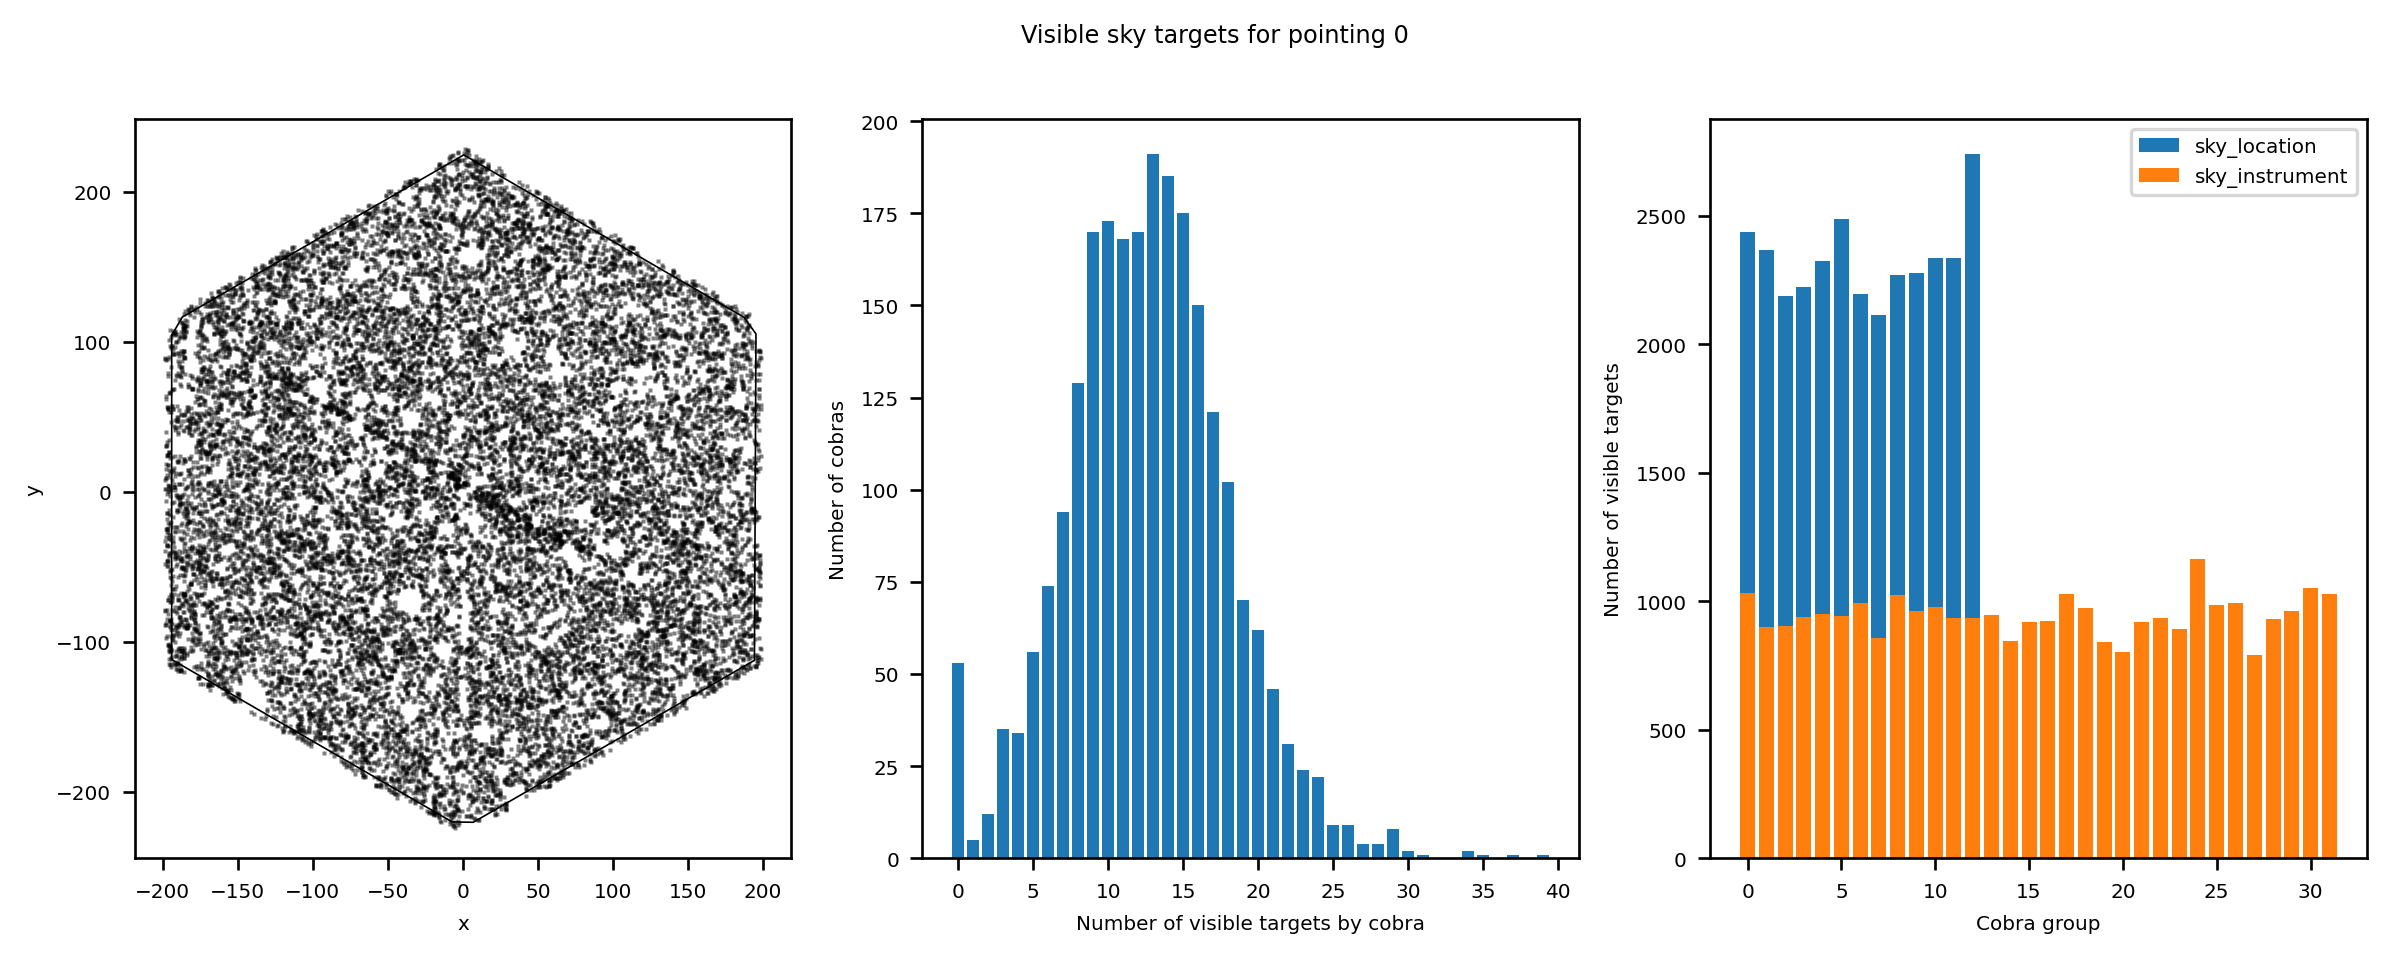

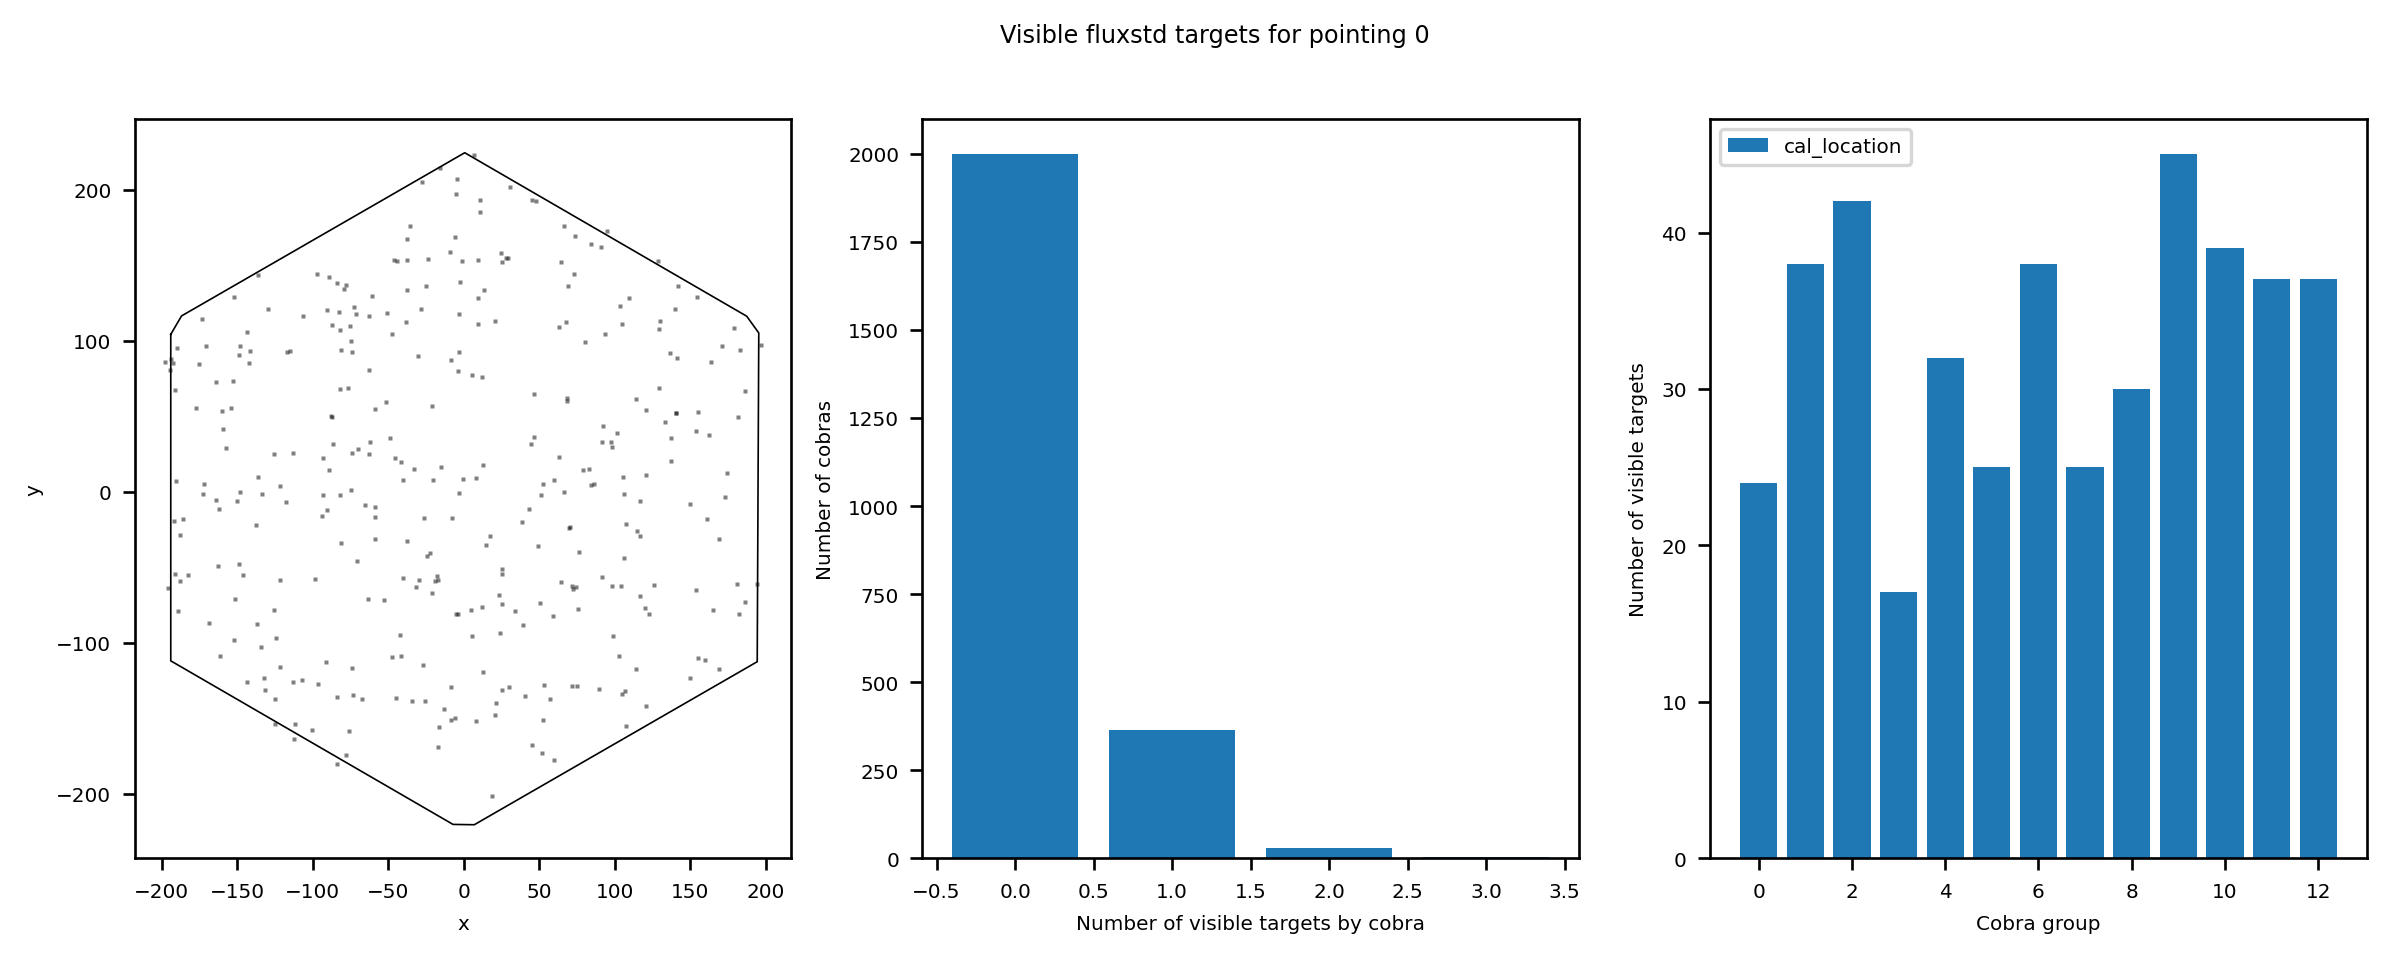

In [65]:
for k in config.targets:
    for i, p in enumerate(config.pointings):
        print(p.ra, p.dec, p.posang, p.obs_time)
        if k in target_lists:
            plot_visible(p, target_lists[k], prefix=config.targets[k].prefix, title=f'Visible {k} targets for pointing {i}')